# 第四組 Lab 3 - Python 自然語言處理套件斷詞比較

In [37]:
import pandas as pd
import numpy as np
import random
from importlib import reload
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from zhon.hanzi import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 讀取資料與篩選

* 資料選擇：從「夢工場」頻道中隨機抽取一萬筆留言，該頻道主要販售床鋪相關商品與助眠產品。
* 選擇原因：希望選擇同一個頻道的留言進行分析，而所有頻道中「夢工場」有超過一萬則留言總數，且瀏覽過後發現其銷售的產品種類較相似、不會過於繁雜。
* 可能用途：了解頻道售貨反饋與品牌忠誠度。

In [4]:
# 讀取資料
df_all = pd.read_csv("../Lab2-tokenization/comment_ge20.csv")
df_all["LEN"] = df_all["MESSAGE"].apply(lambda x: len(x))
df_all.sort_values(by="LEN", inplace=True)
df_all

CHANNEL NAME  USER ID          VIDEO ID  MESSAGE SEQ  \
12001   拼鮮水產 足度男直播買賣  17614.0  3115871558666529       4169.0   
9159             夢工場   6112.0  7450657568308941       1363.0   
44084           阿清服裝   6897.0  4727978617302867      28829.0   
74103      邦成-自倉(抓單)  11566.0  5383539278390225        844.0   
113553         工讀生寵物   4460.0  2986390708333181        154.0   
...              ...      ...               ...          ...   
4626            阿清服裝   6897.0  4635797246521005      45348.0   
17090      邦成-自倉(抓單)  11566.0  2271367169699673       7908.0   
24417      邦成-自倉(抓單)  11566.0  2275117825991274       5652.0   
24420      邦成-自倉(抓單)  11566.0  2275117825991274       5947.0   
2529            阿清服裝   6897.0  4617917701642293      92862.0   

                 FROM_ID                                            MESSAGE  \
12001   6627795243927581                               至少煮的鍋具，是沒鐵氟龍毒毒毒，的，合理   
9159    2253480868035457                               6203簿床四雙人+1簿床四雙人6236   
44084   2870275463068245                             讚嘆小蘇+1\n讚嘆小蘇+1\n讚嘆小蘇+1   
74103   5040639546015978                               去醫美真的每次花都好幾萬 可以買好多瓶了   
113553  1537742783197988                               Linda Wu  您在嗎??換您囉!!   
...                  ...                                                ...   
4626    2793994717397040  ❤️❤️小禮物+1❤️❤️❤️小禮物+1❤️❤️❤️小禮物+1❤️❤️❤️小禮物+1❤️❤️...   
17090    203944296441981  前面標請點開查看更多\n過標的商品5-15分入單!!\n\nA01+數量 $49 (要一箱+...   
24417    203944296441981  前面標請點開查看更多\n過標的商品5-15分入單!!\n\nA01+數量 $899\n(3盒...   
24420    203944296441981  前面標請點開查看更多\n過標的商品5-15分入單!!\n\nA01+數量 $899\n(3盒...   
2529    2793994717397040  精品之夜+1❤️❤️❤️精品之夜+1❤️❤️❤️精品之夜+1❤️❤️❤️精品之夜+1❤️❤️...   

                    CREATED_TIME   LEN  
12001   2022-04-06T10:32:06+0000    20  
9159        2022-04-04T13:28:37Z    20  
44084       2022-04-28T13:17:58Z    20  
74103   2022-08-11T03:22:03+0000    20  
113553      2022-09-13T08:19:41Z    20  
...                          ...   ...  
4626        2022-03-27T13:31:18Z  2124  
17090   2022-04-09T13:44:01+0000  2181  
24417   2022-04-13T14:10:26+0000  2233  
24420   2022-04-13T14:17:48+0000  2599  
2529        2022-03-20T19:53:55Z  2652  

[123882 rows x 8 columns]

In [5]:
# 查看每個店家的總留言數量，要選擇留言總數大於一萬筆的店家
df_all[["MESSAGE","CHANNEL NAME"]].groupby(["CHANNEL NAME"]).count()

MESSAGE
CHANNEL NAME                
251.TC(貳伍壹潮流店)          4618
279-🛒現貨直播車              3462
279-🛒現貨直播車(怡君服飾)         192
TR Box寶藏屋：傘的專家、居的職人    10651
夢工場                    10774
工讀生寵物                  12818
拼鮮水產 足度男直播買賣           12890
蔥媽媽直播                   1768
蔥媽媽直播(蔥媽媽食材有限公司)        5621
邦成-自倉(抓單)              44892
阿清服裝                   16196

In [6]:
# 隨機選擇夢工場的一萬筆留言作為後續分析資料
random.seed(1017) # 設定隨機種子，確保每次執行都是一樣的結果
message = df_all[df_all["CHANNEL NAME"]=="夢工場"].iloc[random.sample([x for x in range(10774)], k=10000),].sort_values(by="LEN")["MESSAGE"].tolist() # 隨機抽取10000筆，按照留言字數長度排序，並取出MESSAGE存成list
print(message[:3])
print(len(message))

['幫我改8118舖四雙人、8202舖四加大', '我兒子👦超愛60細棉夏被的，都早早去睡了', '昨天下的單子打錯了. 請幫我消掉. 謝謝']
10000


# 套件選擇與安裝

* CKIPtagger: 先前都以Jieba斷詞居多，本次Lab想嘗試沒用過但常見的套件，當屬中研院開發的CKIPtagger。
* CoreNLP: 主流NLP工具，演算法又是最新的，必須納入比較。
* SnowNLP: 可以進行情感分析的套件，也想嘗試看看。
* Jieba: 還是納入比較，但主要是觀察其他三個套件的效果。

安裝完成後，此節也會比較套件載入時間，會先在重啟核心(kernel)後載入單一套件(標示為initial)，隨後以reload()重新載入套件兩次(標示為first及second)，就不用重新啟動核心。

參考文獻：Yeh, W. C., Hsieh, Y. L., Chang, Y. C., & Hsu, W. L. (2022). 正體中文斷詞系統應用於大型語料庫之多方評估研究.

In [ ]:
# !pip install tensorflow
# !pip install -U 'ckiptagger[tf,gdown]'
# !pip install stanfordcorenlp
# !pip install snownlp

# reference:
# https://github.com/ckiplab/ckiptagger/wiki/Chinese-README
# https://clay-atlas.com/blog/2019/07/29/stanford-corenlp-教學-by-python/
# https://zhuanlan.zhihu.com/p/391608286

In [5]:
# 比較套件載入時間
import_time = []
for i in ["initial", "first", "second"]:
    if i == "initial":
        start = time.time()
        import ckiptagger # CKIPtagger
        end = time.time()
        ckip = end-start
        import_time.extend([[i, "CKIPtagger", round(ckip*1000,4)]])

        start = time.time()
        import stanfordcorenlp # CoreNLP
        end = time.time()
        core = end-start
        import_time.extend([[i, "CoreNLP", round(core*1000,4)]])

        start = time.time()
        import snownlp # SnowNLP
        end = time.time()
        snow = end-start
        import_time.extend([[i, "SnowNLP", round(snow*1000,4)]])

        start = time.time()
        import jieba # jieba
        end = time.time()
        snow = end-start
        import_time.extend([[i, "Jieba", round(snow*1000,4)]])
    else:
        start = time.time()
        reload(ckiptagger) # CKIPtagger
        end = time.time()
        ckip = end-start
        import_time.extend([[i, "CKIPtagger", round(ckip*1000,4)]])

        start = time.time()
        reload(stanfordcorenlp) # CoreNLP
        end = time.time()
        core = end-start
        import_time.extend([[i, "CoreNLP", round(core*1000,4)]])

        start = time.time()
        reload(snownlp) # SnowNLP
        end = time.time()
        snow = end-start
        import_time.extend([[i, "SnowNLP", round(snow*1000,4)]])

        start = time.time()
        reload(jieba) # Jieba
        end = time.time()
        snow = end-start
        import_time.extend([[i, "Jieba", round(snow*1000,4)]])

import_time_table = pd.DataFrame(import_time, columns=["執行次數", "套件", "執行時間(ms)"])
import_time_table

執行次數          套件   執行時間(ms)
0   initial  CKIPtagger  1871.0761
1   initial     CoreNLP     1.8711
2   initial     SnowNLP  1124.0542
3   initial       Jieba     5.8889
4     first  CKIPtagger     0.1240
5     first     CoreNLP     0.0868
6     first     SnowNLP     0.1132
7     first       Jieba     0.1590
8    second  CKIPtagger     0.0808
9    second     CoreNLP     0.0687
10   second     SnowNLP     0.0880
11   second       Jieba     0.1481

(0.0, 1.0)

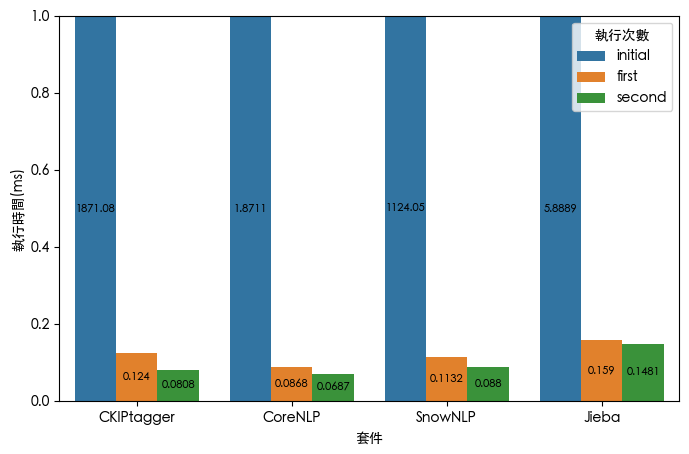

In [8]:
# 繪製直方圖比較
matplotlib.rcParams['font.family'] = "HeiTi TC" # 設定中文字體
plt.figure(figsize =(8,5)) # 設定圖片大小
ax = sns.barplot(x="套件", y="執行時間(ms)", hue="執行次數", data=import_time_table) # 繪製直方圖
ax.bar_label(ax.containers[0], fontsize=8, label_type="center") # 加數值標籤
ax.bar_label(ax.containers[1], fontsize=8, label_type="center") # 加數值標籤
ax.bar_label(ax.containers[2], fontsize=8, label_type="center") # 加數值標籤
plt.ylim(0,1) # 為方便觀察差異，限制y軸範圍介於0~1
# 發現初次載入執行時間是 CKIPtagger > SnowNLP > Jieba > CoreNLP
# 後續載入執行時間都是 Jieba > CKIPtagger > SnowNLP > CoreNLP

# 斷詞與執行時間

## CKIPtagger

In [1]:
# CKIPtagger 使用 CPU
from ckiptagger import data_utils, WS, POS, NER
ws = WS("/Users/jenny/CodeStuff/CKIP/data")

/Users/jenny/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jenny/Library/Python/3.9/lib/python/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2023-10-16 18:53:44.979814: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


In [12]:
# 測試一則留言斷詞
ws([message[0]])[0]

['幫', '我', '改', '8118', '舖', '四', '雙', '人', '、', '8202', '舖', '四', '加大']

In [15]:
# 所有留言斷詞
result = []
package = "CKIPtagger"
total_spend = 0
for i, mess in enumerate(message):
    start = time.time()
    cut = ws([mess])[0]
    end = time.time()
    spend = end-start
    total_spend += spend
    result.extend([[package, i, mess, "/".join(cut), round(spend*1000,4), round(total_spend*1000,4)]])
result_df1 = pd.DataFrame(result, columns=["套件", "id", "原始留言", "斷詞結果", "執行時間(ms)", "累計執行時間(ms)"])
result_df1

套件    id                                               原始留言  \
0     CKIPtagger     0                               幫我改8118舖四雙人、8202舖四加大   
1     CKIPtagger     1                               我兒子👦超愛60細棉夏被的，都早早去睡了   
2     CKIPtagger     2                               昨天下的單子打錯了. 請幫我消掉. 謝謝   
3     CKIPtagger     3                               請問這個跟剛才2組3980的有何不同呢？   
4     CKIPtagger     4                               阿公說女神剪短髮好俏麗，像女大學生👩‍🎓   
...          ...   ...                                                ...   
9995  CKIPtagger  9995  7S -77 珍珠天絲   醋酸纖維(乙酸)\n\n生產工藝\n醋酸纖維取材於可再生的木漿與...   
9996  CKIPtagger  9996  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
9997  CKIPtagger  9997  多美丽的玫瑰花\n多可爱的玫瑰花\n我就这样深深的爱上她\n多美丽的玫瑰花\n多可爱的玫瑰花...   
9998  CKIPtagger  9998  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
9999  CKIPtagger  9999  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   

                                                   斷詞結果  執行時間(ms)   累計執行時間(ms)  
0                      幫/我/改/8118/舖/四/雙/人/、/8202/舖/四/加大   16.2849      16.2849  
1                   我/兒子/👦/超/愛/60/細/棉/夏被/的/，/都/早早/去/睡/了   13.4110      29.6960  
2                    昨天/下/的/單子/打錯/了/./ /請/幫/我/消掉/./ /謝謝   11.7331      41.4290  
3                     請問/這/個/跟/剛才/2/組/3980/的/有/何/不同/呢/？    8.2331      49.6621  
4                       阿公/說/女神/剪/短髮/好/俏麗/，/像/女/大學生/👩‍🎓   10.4289      60.0910  
...                                                 ...       ...          ...  
9995  7S -77 /珍珠/天絲/   /醋酸/纖維/(/乙酸/)/\n\n/生產/工藝/\n醋酸...  262.9828  318266.2921  
9996  ⚠停/~/止/～/關/~/鍵/~/字/~⚠\n/持續/分享/+/按/讚😘 😘 😘\n⚠/停/...  278.9309  318545.2230  
9997  多/美丽/的/玫瑰/花\n/多/可/爱/的/玫瑰/花\n/我/就/这样/深深/的/爱/上/她...  280.7581  318825.9811  
9998  ⚠停/~/止/～/關/~/鍵/~/字/~⚠\n/持續/分享/+/按/讚😘 😘 😘\n⚠/停/...  318.4311  319144.4123  
9999  ⚠停/~/止/～/關/~/鍵/~/字/~⚠\n/持續/分享/+/按/讚😘 😘 😘\n⚠/停/...  375.3932  319519.8054  

[10000 rows x 6 columns]

## CoreNLP

In [9]:
# CoreNLP
from stanfordcorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP('/Users/jenny/CodeStuff/CoreNLP/stanford-corenlp-full-2023-10-14', lang='zh')

In [10]:
# 測試一則留言斷詞
nlp.word_tokenize(message[0])

['幫', '我', '改', '8118', '舖', '四', '雙人', '、', '8202', '舖四', '加大']

In [10]:
# 所有留言斷詞
result = []
package = "CoreNLP"
total_spend = 0
for i, mess in enumerate(message):
    start = time.time()
    cut = nlp.word_tokenize(mess)
    end = time.time()
    spend = end-start
    total_spend += spend
    result.extend([[package, i, mess, "/".join(cut), round(spend*1000,4), round(total_spend*1000,4)]])
result_df2 = pd.DataFrame(result, columns=["套件", "id", "原始留言", "斷詞結果", "執行時間(ms)", "累計執行時間(ms)"])
result_df2

套件    id                                               原始留言  \
0     CoreNLP     0                               幫我改8118舖四雙人、8202舖四加大   
1     CoreNLP     1                               我兒子👦超愛60細棉夏被的，都早早去睡了   
2     CoreNLP     2                               昨天下的單子打錯了. 請幫我消掉. 謝謝   
3     CoreNLP     3                               請問這個跟剛才2組3980的有何不同呢？   
4     CoreNLP     4                               阿公說女神剪短髮好俏麗，像女大學生👩‍🎓   
...       ...   ...                                                ...   
9995  CoreNLP  9995  7S -77 珍珠天絲   醋酸纖維(乙酸)\n\n生產工藝\n醋酸纖維取材於可再生的木漿與...   
9996  CoreNLP  9996  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
9997  CoreNLP  9997  多美丽的玫瑰花\n多可爱的玫瑰花\n我就这样深深的爱上她\n多美丽的玫瑰花\n多可爱的玫瑰花...   
9998  CoreNLP  9998  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
9999  CoreNLP  9999  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   

                                                   斷詞結果  執行時間(ms)  累計執行時間(ms)  
0                        幫/我/改/8118/舖/四/雙人/、/8202/舖四/加大   13.5398     13.5398  
1                    我/兒子/👦/超愛/60/細/棉夏/被/的/，/都/早早/去/睡/了   31.8511     45.3908  
2                         昨天/下/的/單子/打錯/了/./請幫/我/消掉/./謝謝   21.0023     66.3931  
3                        請問這個/跟剛/才/2/組/3980/的/有何/不同/呢/？   19.8679     86.2610  
4                         阿公說/女神/剪短/髮好/俏麗/，/像/女大/學生/👩‍🎓   10.7379     96.9989  
...                                                 ...       ...         ...  
9995  7S/-77/珍珠/天絲/醋酸/纖維/(/乙酸/)/生產/工藝/醋酸/纖維/取材於/可/再生...   11.4338  44294.0545  
9996  ⚠停/~/止/～關/~/鍵/~/字/~/⚠/持續/分享/按/讚😘/😘/😘/⚠停/~/止/～關...    9.6440  44303.6985  
9997  多/美丽/的/玫瑰花/多/可爱/的/玫瑰/花/我/就/这样/深深/的/爱上/她/多/美丽/的...   11.6048  44315.3033  
9998  ⚠停/~/止/～關/~/鍵/~/字/~/⚠/持續/分享/按/讚😘/😘/😘/⚠停/~/止/～關...   11.0898  44326.3931  
9999  ⚠停/~/止/～關/~/鍵/~/字/~/⚠/持續/分享/按/讚😘/😘/😘/⚠停/~/止/～關...   33.3230  44359.7162  

[10000 rows x 6 columns]

## SnowNLP

In [11]:
# SnowNLP
from snownlp import SnowNLP

In [12]:
# 測試一則留言斷詞
SnowNLP(message[0]).words

['幫', '我', '改', '8118', '舖', '四', '雙', '人', '、8202', '舖', '四', '加大']

In [13]:
# 所有留言斷詞
result = []
package = "SnowNLP"
total_spend = 0
for i, mess in enumerate(message):
    start = time.time()
    cut = SnowNLP(mess).words
    end = time.time()
    spend = end-start
    total_spend += spend
    result.extend([[package, i, mess, "/".join(cut), round(spend*1000,4), round(total_spend*1000,4)]])
result_df3 = pd.DataFrame(result, columns=["套件", "id", "原始留言", "斷詞結果", "執行時間(ms)", "累計執行時間(ms)"])
result_df3

套件    id                                               原始留言  \
0     SnowNLP     0                               幫我改8118舖四雙人、8202舖四加大   
1     SnowNLP     1                               我兒子👦超愛60細棉夏被的，都早早去睡了   
2     SnowNLP     2                               昨天下的單子打錯了. 請幫我消掉. 謝謝   
3     SnowNLP     3                               請問這個跟剛才2組3980的有何不同呢？   
4     SnowNLP     4                               阿公說女神剪短髮好俏麗，像女大學生👩‍🎓   
...       ...   ...                                                ...   
9995  SnowNLP  9995  7S -77 珍珠天絲   醋酸纖維(乙酸)\n\n生產工藝\n醋酸纖維取材於可再生的木漿與...   
9996  SnowNLP  9996  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
9997  SnowNLP  9997  多美丽的玫瑰花\n多可爱的玫瑰花\n我就这样深深的爱上她\n多美丽的玫瑰花\n多可爱的玫瑰花...   
9998  SnowNLP  9998  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
9999  SnowNLP  9999  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   

                                                   斷詞結果  執行時間(ms)  累計執行時間(ms)  
0                       幫/我/改/8118/舖/四/雙/人/、8202/舖/四/加大    0.9739      0.9739  
1                   我/兒子/👦/超/愛/60/細/棉夏/被/的/，/都/早早/去/睡/了    1.9121      2.8861  
2                     昨天/下/的/單/子/打/錯/了/./請/幫我/消/掉/./謝/謝    1.5099      4.3960  
3                   請/問/這/個/跟/剛/才/2/組/3980/的/有/何/不同/呢/？    1.1632      5.5592  
4                   阿/公/說/女神/剪/短/髮/好俏/麗/，/像/女/大/學/生/👩‍🎓    1.4970      7.0562  
...                                                 ...       ...         ...  
9995  7S/-77/珍/珠天/絲/醋/酸/纖/維/(/乙酸/)/生/產/工/藝/醋/酸/纖/維/取...   16.1581   9522.1345  
9996  ⚠/停/~/止/～/關/~/鍵/~/字/~⚠/持/續/分享/+/按/讚/😘/😘/😘/⚠/停/...    2.8210   9524.9555  
9997  多/美丽/的/玫瑰/花/多/可爱/的/玫瑰/花/我/就/这样/深深/的/爱/上/她/多/美丽...   21.3666   9546.3221  
9998  ⚠/停/~/止/～/關/~/鍵/~/字/~⚠/持/續/分享/+/按/讚/😘/😘/😘/⚠/停/...    3.4831   9549.8052  
9999  ⚠/停/~/止/～/關/~/鍵/~/字/~⚠/持/續/分享/+/按/讚/😘/😘/😘/⚠/停/...    4.0698   9553.8750  

[10000 rows x 6 columns]

## Jieba

In [13]:
# jieba
import jieba

In [15]:
# 測試一則留言斷詞
jieba.lcut(message[0])

['幫', '我', '改', '8118', '舖', '四', '雙人', '、', '8202', '舖', '四', '加大']

In [8]:
# 所有留言斷詞
result = []
package = "Jieba"
total_spend = 0
for i, mess in enumerate(message):
    start = time.time()
    cut = jieba.lcut(mess)
    end = time.time()
    spend = end-start
    total_spend += spend
    result.extend([[package, i, mess, "/".join(cut), round(spend*1000,4), round(total_spend*1000,4)]])
result_df4 = pd.DataFrame(result, columns=["套件", "id", "原始留言", "斷詞結果", "執行時間(ms)", "累計執行時間(ms)"])
result_df4

套件    id                                               原始留言  \
0     Jieba     0                               幫我改8118舖四雙人、8202舖四加大   
1     Jieba     1                               我兒子👦超愛60細棉夏被的，都早早去睡了   
2     Jieba     2                               昨天下的單子打錯了. 請幫我消掉. 謝謝   
3     Jieba     3                               請問這個跟剛才2組3980的有何不同呢？   
4     Jieba     4                               阿公說女神剪短髮好俏麗，像女大學生👩‍🎓   
...     ...   ...                                                ...   
9995  Jieba  9995  7S -77 珍珠天絲   醋酸纖維(乙酸)\n\n生產工藝\n醋酸纖維取材於可再生的木漿與...   
9996  Jieba  9996  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
9997  Jieba  9997  多美丽的玫瑰花\n多可爱的玫瑰花\n我就这样深深的爱上她\n多美丽的玫瑰花\n多可爱的玫瑰花...   
9998  Jieba  9998  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
9999  Jieba  9999  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   

                                                   斷詞結果  執行時間(ms)  累計執行時間(ms)  
0                       幫/我/改/8118/舖/四/雙人/、/8202/舖/四/加大    0.1731      0.1731  
1                     我兒子/👦/超愛/60/細棉/夏/被/的/，/都/早早/去/睡/了    0.2277      0.4008  
2                    昨天/下/的/單子/打錯/了/./ /請/幫/我/消掉/./ /謝謝    0.1469      0.5476  
3                       請問/這個/跟/剛才/2/組/3980/的/有何/不同/呢/？    0.1249      0.6726  
4                      阿公/說/女神/剪短/髮/好/俏麗/，/像/女大學生/👩/‍/🎓    0.1242      0.7968  
...                                                 ...       ...         ...  
9995  7S/ /-/77/ /珍珠/天絲/ / / /醋酸/纖維/(/乙酸/)/\n/\n/生產/...    0.5858    659.3027  
9996  ⚠/停/~/止/～/關/~/鍵/~/字/~/⚠/\n/持續/分享/+/按/讚/😘/ /😘/ ...    0.3080    659.6107  
9997  多/美丽/的/玫瑰花/\n/多/可爱/的/玫瑰花/\n/我/就/这样/深深/的/爱/上/她/...    0.5338    660.1446  
9998  ⚠/停/~/止/～/關/~/鍵/~/字/~/⚠/\n/持續/分享/+/按/讚/😘/ /😘/ ...    0.3531    660.4977  
9999  ⚠/停/~/止/～/關/~/鍵/~/字/~/⚠/\n/持續/分享/+/按/讚/😘/ /😘/ ...    0.4070    660.9046  

[10000 rows x 6 columns]

## 繪圖比較

In [2]:
result_df1 = pd.read_csv("result_df1.csv")
result_df2 = pd.read_csv("result_df2.csv")
result_df3 = pd.read_csv("result_df3.csv")
result_df4 = pd.read_csv("result_df4.csv")

In [3]:
# 合併三種套件的執行結果
result_df = pd.concat([result_df1, result_df2, result_df3, result_df4], ignore_index=True)
result_df

套件    id                                               原始留言  \
0      CKIPtagger     0                               幫我改8118舖四雙人、8202舖四加大   
1      CKIPtagger     1                               我兒子👦超愛60細棉夏被的，都早早去睡了   
2      CKIPtagger     2                               昨天下的單子打錯了. 請幫我消掉. 謝謝   
3      CKIPtagger     3                               請問這個跟剛才2組3980的有何不同呢？   
4      CKIPtagger     4                               阿公說女神剪短髮好俏麗，像女大學生👩‍🎓   
...           ...   ...                                                ...   
39995       Jieba  9995  7S -77 珍珠天絲   醋酸纖維(乙酸)\n\n生產工藝\n醋酸纖維取材於可再生的木漿與...   
39996       Jieba  9996  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
39997       Jieba  9997  多美丽的玫瑰花\n多可爱的玫瑰花\n我就这样深深的爱上她\n多美丽的玫瑰花\n多可爱的玫瑰花...   
39998       Jieba  9998  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   
39999       Jieba  9999  ⚠停~止～關~鍵~字~⚠\n持續分享+按讚😘 😘 😘\n⚠停~止～關~鍵~字~⚠\n持續分享...   

                                                    斷詞結果  執行時間(ms)  累計執行時間(ms)  
0                       幫/我/改/8118/舖/四/雙/人/、/8202/舖/四/加大   16.2849     16.2849  
1                    我/兒子/👦/超/愛/60/細/棉/夏被/的/，/都/早早/去/睡/了   13.4110     29.6960  
2                     昨天/下/的/單子/打錯/了/./ /請/幫/我/消掉/./ /謝謝   11.7331     41.4290  
3                      請問/這/個/跟/剛才/2/組/3980/的/有/何/不同/呢/？    8.2331     49.6621  
4                        阿公/說/女神/剪/短髮/好/俏麗/，/像/女/大學生/👩‍🎓   10.4289     60.0910  
...                                                  ...       ...         ...  
39995  7S/ /-/77/ /珍珠/天絲/ / / /醋酸/纖維/(/乙酸/)/\n/\n/生產/...    0.5858    659.3027  
39996  ⚠/停/~/止/～/關/~/鍵/~/字/~/⚠/\n/持續/分享/+/按/讚/😘/ /😘/ ...    0.3080    659.6107  
39997  多/美丽/的/玫瑰花/\n/多/可爱/的/玫瑰花/\n/我/就/这样/深深/的/爱/上/她/...    0.5338    660.1446  
39998  ⚠/停/~/止/～/關/~/鍵/~/字/~/⚠/\n/持續/分享/+/按/讚/😘/ /😘/ ...    0.3531    660.4977  
39999  ⚠/停/~/止/～/關/~/鍵/~/字/~/⚠/\n/持續/分享/+/按/讚/😘/ /😘/ ...    0.4070    660.9046  

[40000 rows x 6 columns]

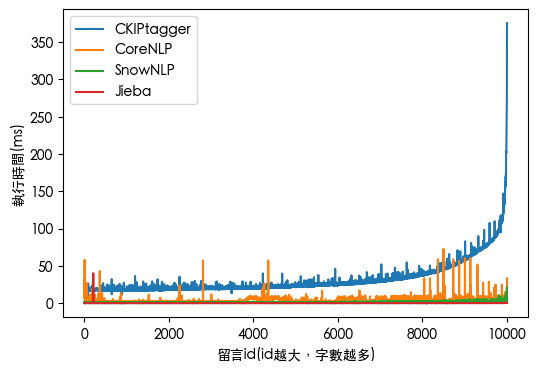

In [13]:
# 執行時間
matplotlib.rcParams['font.family'] = "HeiTi TC"
plt.figure(figsize=(6, 4)) 
for pack in ["CKIPtagger", "CoreNLP", "SnowNLP", "Jieba"]:
    plt.plot(result_df["id"][result_df["套件"]==pack], result_df["執行時間(ms)"][result_df["套件"]==pack], label=pack)
plt.legend(["CKIPtagger", "CoreNLP", "SnowNLP", "Jieba"], loc="upper left")
plt.xlabel("留言id(id越大，字數越多)")
plt.ylabel("執行時間(ms)")
plt.show()
# 隨著留言字數的增加，執行時間有增加的趨勢，且 CKIPtagger > CoreNLP > SnowNLP > Jieba，其中又以 CKIPtagger 的增幅最大

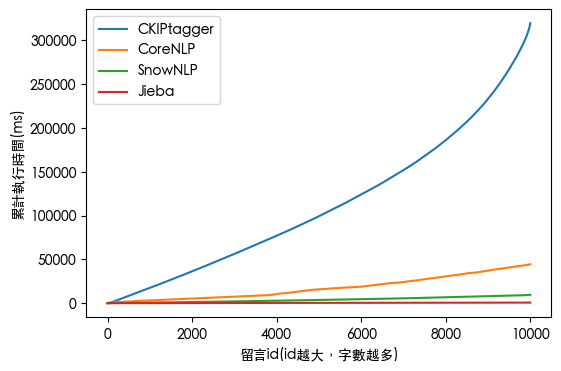

In [14]:
# 累計執行時間
matplotlib.rcParams['font.family'] = "HeiTi TC"
plt.figure(figsize=(6, 4)) 
for pack in ["CKIPtagger", "CoreNLP", "SnowNLP", "Jieba"]:
    plt.plot(result_df["id"][result_df["套件"]==pack], result_df["累計執行時間(ms)"][result_df["套件"]==pack], label=pack)
plt.legend(["CKIPtagger", "CoreNLP", "SnowNLP", "Jieba"], loc="upper left")
plt.xlabel("留言id(id越大，字數越多)")
plt.ylabel("累計執行時間(ms)")
plt.show()
# 整體執行時間 CKIPtagger > CoreNLP > SnowNLP > Jieba，且呼應上張圖，CKIPtagger 在越長的留言所需執行時間增幅最大（觀察斜率）

# 抽樣計算正確率
從10,000則留言中隨機抽樣10則進行人工標記，用以比較斷詞結果的正確性。

In [7]:
# 簡單隨機抽樣10則
random.seed(2023) # 設定隨機種子，確保每次執行都是一樣的結果
check_index = sorted(random.sample([x for x in range(10000)], k=30))
check = [message[i] for i in check_index]
check

['7315一整組啦，不要多整頭套了😘😘😘😘',
 '床上的帝王棉特大舖包+2 改90x200',
 '請問兩用被，有沒有沒有鋪棉的可以塞冬被嗎？',
 '1049，1020，9149特大床罩各一組',
 '8235單人薄三+1\n8212加大薄三+1',
 '7124雙人舖三+1，7122雙人舖三+1',
 '可以幫我把購物車裡的N44保溫瓶訂單取消嗎？',
 '先入手60細棉，再慢慢來提升，真得超級舒服😌',
 '可以去門市摸材質…然後在來直播喊單…最划算的',
 '睡過你們家的床罩￼￼😂就回不去了😂￼真的舒服￼',
 'W12- 厚磅雲絨毯 150x200 $599',
 '@Hang Nguyen  您要凍凍被+舖三?',
 '仙姑晚上如果睡不著不要….捅褲子，都捅破了🤣🤣🤣',
 '7159加起來~~真的好漂亮..舖在床上很療癒喔',
 '請問我昨晚的6107加大舖四可以換6200加大床罩嗎？',
 '請問8212  8201 有薄三特大嗎？請問多少錢呢？',
 '61高貴/56仙氣/60低調美....三組通通包軌😳😳😳',
 '購物車寫7316涼被+2，應該是7311+1和7316+1',
 '埃及棉全尺寸均一價\n薄四2088\n舖四2280\n薄三999',
 '我昨天有買8147的薄三加大的，想改薄四加大的，麻煩你了，🥰',
 '我老公說我睡v68會打呼，睡v39就不會了，不然我很愛睡v68😅',
 '🎨兩用被/可入冬被180x210cm\n💦涼被：150x180cm',
 '恭喜中獎購物金$100\nVicky Hsueh/談如芬/Sinen Tseng',
 '男神，不好意思，4/8號訂購2組6164，6014到目前還沒收到貨。。很急😭😭',
 '吃再高級的大餐終究要回歸自然（便所）還是擁有帶來心靈富足慰藉的寢具才是最幸福快樂的👍👍👍👍👍',
 '帝王棉期間下殺 💯🤩\n(全尺寸均一價)\n🍭薄包四件組3399\n🍭舖包四件組3699\n🍭床罩四件組3999',
 'T54 -胖胖保溫瓶 1000ML (淺藍/粉/白/綠) $188\nT53 -夢幻水壺 1300ML (綠/藍/紫) $139',
 '韓國珍珠錦緞棉\n70%莫代爾+30%韓國棉\n舖三(枕套*2+舖棉床包*1)\n涼被150*180(單人尺寸)\n\n任選二樣 1988元',

In [42]:
# 將人工標記結果儲存成list
true_cut = ['7315/一/整組/啦/，/不要/多/整頭套/了/😘/😘/😘/😘',
 '床上/的/帝王棉/特大/舖包/+/2/ /改/90/x/200',
 '請問/兩用被/，/有沒有/沒有/鋪棉/的/可以/塞/冬被/嗎/？',
 '1049/，/1020/，/9149/特大/床罩/各/一/組',
 '8235/單人/薄三/+/1/\n/8212/加大/薄三/+/1',
 '7124/雙人/舖三/+/1/，/7122/雙人/舖三/+/1',
 '可以/幫/我/把/購物車/裡/的/N44/保溫瓶/訂單/取消/嗎/？',
 '先/入手/60/細棉/，/再/慢慢/來/提升/，/真得/超級/舒服/😌',
 '可以/去/門市/摸/材質/…/然後/在來/直播/喊單/…/最/划算/的',
 '睡過/你們/家/的/床罩/￼/￼/😂/就/回不去/了/😂/￼/真的/舒服/￼',
 'W12/-/ /厚磅/雲絨毯/ /150/x/200/ /$/599',
 '@/Hang Nguyen/ / /您/要/凍凍被/+/舖三/?',
 '仙姑/晚上/如果/睡不著/不要/…/./捅/褲子/，/都/捅破/了/🤣/🤣/🤣',
 '7159/加起來/~/~/真的/好/漂亮/././舖/在/床上/很/療癒/喔',
 '請問/我/昨晚/的/6107/加大/舖四/可以/換/6200/加大/床罩/嗎/？',
 '請問/8212/ / /8201/ /有/薄三/特大/嗎/？/請問/多少/錢/呢/？',
 '61/高貴///56/仙氣///60/低調/美/././././三組/通通/包軌/😳/😳/😳',
 '購物車/寫/7316/涼被/+/2/，/應該/是/7311/+/1/和/7316/+/1',
 '埃及棉/全尺寸/均一價/\n/薄四/2088/\n/舖四/2280/\n/薄三/999',
 '我/昨天/有/買/8147/的/薄三/加大/的/，/想/改/薄四/加大/的/，/麻煩/你/了/，/🥰',
 '我/老公/說/我/睡/v68/會/打呼/，/睡/v39/就/不會/了/，/不然/我/很/愛/睡/v68/😅',
 '🎨/兩用被///可/入冬被/180/x/210/cm/\n/💦/涼被/：/150/x/180/cm',
 '恭喜/中獎/購物金/$/100/\n/Vicky Hsueh///談如芬///Sinen Tseng',
 '男神/，/不好意思/，/4/8號/訂購/2/組/6164/，/6014/到/目前/還沒/收到/貨/。/。/很/急/😭/😭',
 '吃/再/高級/的/大餐/終究/要/回歸/自然/（/便所/）/還是/擁有/帶來/心靈/富足/慰藉/的/寢具/才是/最/幸福/快樂/的/👍/👍/👍/👍/👍',
 '帝王棉/期間/下殺/ /💯/🤩/\n/(/全/尺寸/均一價/)/\n/🍭/薄包/四件/組/3399/\n/🍭/舖包/四件/組/3699/\n/🍭/床罩/四件/組/3999',
 'T54/ /-/胖胖/保溫瓶/ /1000/ML/ /(/淺藍///粉///白///綠/)/ /$/188/\n/T53/ /-/夢幻/水壺/ /1300/ML/ /(/綠///藍///紫/)/ /$/139',
 '韓國/珍珠錦緞棉/\n/70/%/莫代爾/+/30/%/韓國棉/\n/舖三/(/枕套/*/2/+/舖棉/床包/*/1/)/\n/涼被/150/*/180/(/單人/尺寸/)/\n/\n/任選/二樣/ /1988/元',
 'V05/ /蝶型/曲線/乳膠枕/ /(/個/)/ /$/800/\n/Q98/ /天絲/長枕/ /(/隨機/不挑花/)/\n/$/399/ /\n/Q97-4/ /天絲/腰靠枕/(/限量/花型/)/$/139',
 '3M40/舒爽/天絲/\n/單///雙人///加大///特大/均一價/\n/薄包/四件/組/ /$/1388/\n/舖包/四件/組/ /$/1588/\n/薄包/三件/組/ /$/588/\n/舖包/三件/組/ /$/888/\n/兩用被/ /$/1088/\n/涼被/$/688/\n/枕頭套/$/199']

In [48]:
# 將三種套件結果合併觀察
check_df = result_df[result_df["原始留言"].isin(check)].iloc[:,:4]
check_df["正確斷詞"] = true_cut*4
check_df["precision"] = [None] * len(check_df)
check_df["recall"] = [None] * len(check_df)
check_df["f1_score"] = [None] * len(check_df)
check_df.reset_index(inplace=True)
check_df.head(3)

index          套件    id                   原始留言  \
0    279  CKIPtagger   279   7315一整組啦，不要多整頭套了😘😘😘😘   
1    637  CKIPtagger   637   床上的帝王棉特大舖包+2 改90x200   
2   1074  CKIPtagger  1074  請問兩用被，有沒有沒有鋪棉的可以塞冬被嗎？   

                                  斷詞結果                              正確斷詞  \
0      7315/一/整/組/啦/，/不要/多/整頭/套/了/😘😘😘😘  7315/一/整組/啦/，/不要/多/整頭套/了/😘/😘/😘/😘   
1      床/上/的/帝王/棉特/大/舖包/+2 /改/90/x/200   床上/的/帝王棉/特大/舖包/+/2/ /改/90/x/200   
2  請問/兩/用/被/，/有沒有/沒有/鋪/棉/的/可以/塞冬/被/嗎/？  請問/兩用被/，/有沒有/沒有/鋪棉/的/可以/塞/冬被/嗎/？   

  precision recall f1_score  
0      None   None     None  
1      None   None     None  
2      None   None     None

In [44]:
# 建立一些後續計算要用的函式

# 把斷詞結果儲存成區間表示
def tokenize_to_intervals(cut_result):
    intervals = []
    tokens = [token for token in cut_result.split('/') if token != '']
    start = 1
    for token in tokens:
        end = start+len(token)-1
        intervals.append([start, end])
        start = end + 1
    return intervals

# 找出交集
def find_intersection(answer_intervals, cut_result_intervals):
    set1 = set(tuple(interval) for interval in answer_intervals)
    set2 = set(tuple(interval) for interval in cut_result_intervals)
    intersection = set1.intersection(set2)
    return [list(interval) for interval in intersection]

# 計算 precision, recall, f1_score
def calculate_metrics(answer, predict):

    answer_intervals = tokenize_to_intervals(answer)
    cut_result_intervals = tokenize_to_intervals(predict)
    intersection = find_intersection(answer_intervals, cut_result_intervals)

    precision = len(intersection)/len(cut_result_intervals)
    recall = len(intersection)/len(answer_intervals)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1_score

# 講義範例
answer = '結婚/的/和/尚未/結婚/的'
predict = '結婚/的/和尚/未結婚/的'
answer_intervals = tokenize_to_intervals(answer)
cut_result_intervals = tokenize_to_intervals(predict)
intersection = find_intersection(answer_intervals, cut_result_intervals)

print("標準答案:", answer_intervals)
print("斷詞結果:", cut_result_intervals)
print("重合部分:", intersection)
print("precision, recall, f1_score:", calculate_metrics(answer, predict))

標準答案: [[1, 2], [3, 3], [4, 4], [5, 6], [7, 8], [9, 9]]
斷詞結果: [[1, 2], [3, 3], [4, 5], [6, 8], [9, 9]]
重合部分: [[1, 2], [3, 3], [9, 9]]
precision, recall, f1_score: (0.6, 0.5, 0.5454545454545454)


In [45]:
for i in range(len(check_df)):
    check_df.iloc[i,6:9] = calculate_metrics(check_df["正確斷詞"][i], check_df["斷詞結果"][i])
check_df

index          套件    id  \
0      279  CKIPtagger   279   
1      637  CKIPtagger   637   
2     1074  CKIPtagger  1074   
3     1150  CKIPtagger  1150   
4     1243  CKIPtagger  1243   
..     ...         ...   ...   
115  38238       Jieba  8238   
116  38644       Jieba  8644   
117  38711       Jieba  8711   
118  38712       Jieba  8712   
119  39355       Jieba  9355   

                                                  原始留言  \
0                                 7315一整組啦，不要多整頭套了😘😘😘😘   
1                                 床上的帝王棉特大舖包+2 改90x200   
2                                請問兩用被，有沒有沒有鋪棉的可以塞冬被嗎？   
3                                1049，1020，9149特大床罩各一組   
4                               8235單人薄三+1\n8212加大薄三+1   
..                                                 ...   
115  帝王棉期間下殺 💯🤩\n(全尺寸均一價)\n🍭薄包四件組3399\n🍭舖包四件組3699\n...   
116  T54 -胖胖保溫瓶 1000ML (淺藍/粉/白/綠) $188\nT53 -夢幻水壺 1...   
117  韓國珍珠錦緞棉\n70%莫代爾+30%韓國棉\n舖三(枕套*2+舖棉床包*1)\n涼被150...   
118  V05 蝶型曲線乳膠枕 (個) $800\nQ98 天絲長枕 (隨機不挑花)\n$399 \...   
119  3M40舒爽天絲\n單/雙人/加大/特大均一價\n薄包四件組 $1388\n舖包四件組 $1...   

                                                  斷詞結果  \
0                      7315/一/整/組/啦/，/不要/多/整頭/套/了/😘😘😘😘   
1                      床/上/的/帝王/棉特/大/舖包/+2 /改/90/x/200   
2                  請問/兩/用/被/，/有沒有/沒有/鋪/棉/的/可以/塞冬/被/嗎/？   
3                           1049，1020，9149/特大/床罩/各/一/組   
4                         8235/單人/薄三/+1\n8212/加大/薄三/+1   
..                                                 ...   
115  帝王/棉期/間/下/殺/ /💯/🤩/\n/(/全/尺寸/均/一價/)/\n/🍭/薄包/四件/...   
116  T54/ /-/胖胖/保溫/瓶/ /1000ML/ /(/淺/藍///粉///白///綠/)...   
117  韓國/珍珠/錦緞/棉/\n/70%/莫代爾/+/30%/韓國/棉/\n/舖/三/(/枕套/*...   
118  V05/ /蝶型/曲線/乳膠/枕/ /(/個/)/ /$/800/\n/Q98/ /天絲長/...   
119  3M40/舒爽/天絲/\n/單///雙人///加大///特大/均/一價/\n/薄包/四件/組...   

                                                  正確斷詞 precision    recall  \
0                     7315/一/整組/啦/，/不要/多/整頭套/了/😘/😘/😘/😘  0.583333  0.538462   
1                      床上/的/帝王棉/特大/舖包/+/2/ /改/90/x/200       0.5       0.5   
2                     請問/兩用被/，/有沒有/沒有/鋪棉/的/可以/塞/冬被/嗎/？  0.533333  0.666667   
3                       1049/，/1020/，/9149/特大/床罩/各/一/組  0.833333       0.5   
4                     8235/單人/薄三/+/1/\n/8212/加大/薄三/+/1  0.714286  0.454545   
..                                                 ...       ...       ...   
115  帝王棉/期間/下殺/ /💯/🤩/\n/(/全/尺寸/均一價/)/\n/🍭/薄包/四件/組/3...  0.735294  0.833333   
116  T54/ /-/胖胖/保溫瓶/ /1000/ML/ /(/淺藍///粉///白///綠/)/...  0.833333  0.833333   
117  韓國/珍珠錦緞棉/\n/70/%/莫代爾/+/30/%/韓國棉/\n/舖三/(/枕套/*/2...  0.634146  0.684211   
118  V05/ /蝶型/曲線/乳膠枕/ /(/個/)/ /$/800/\n/Q98/ /天絲/長枕...  0.738095  0.837838   
119  3M40/舒爽/天絲/\n/單///雙人///加大///特大/均一價/\n/薄包/四件/組/...  0.785714      0.88   

     f1_score  
0        0.56  
1         0.5  
2    0.592593  
3       0.625  
4    0.555556  
..        ...  
115   0.78125  
116  0.833333  
117  0.658228  
118   0.78481  
119  0.830189  

[120 rows x 9 columns]

In [46]:
check_df.to_csv("check_df.csv", index=False)

In [108]:
# 計算不同套件下的 precision, recall, f1_score 平均數與標準差
check_df1_groupby = check_df.groupby('套件').agg({'precision': ['mean', 'std'], 'recall': ['mean', 'std'], 'f1_score': ['mean', 'std']})
check_df1_groupby # 發現CKIPtagger與Jieba表現較好

precision              recall            f1_score          
                mean       std      mean       std      mean       std
套件                                                                    
CKIPtagger   0.69073  0.215028  0.634627  0.213506  0.658012  0.210533
CoreNLP     0.486693  0.273284  0.462313  0.281006  0.472107  0.275609
Jieba       0.744487  0.176244  0.777986  0.157909  0.756884  0.162381
SnowNLP     0.341932  0.188055  0.364426  0.220044  0.348928  0.198496

In [109]:
# 計算抽樣誤差
N = 10000
n = 30
error = pd.DataFrame(columns=['precision', 'recall', 'f1_score'], index=check_df1_groupby.index)
for row in range(4):
    for i,col in enumerate(range(0,6,2)):
        error.iloc[row,i] = 1.96*(((check_df1_groupby.iloc[row,col])**2)*(N-n)/(n*N))**0.5
error

precision    recall  f1_score
套件                                      
CKIPtagger  0.246803  0.226757  0.235113
CoreNLP     0.173899  0.165188  0.168688
Jieba       0.266011  0.277981  0.270441
SnowNLP     0.122175  0.130212  0.124675

In [88]:
# 另一種方法
# 將標點符號與表情符號視為停用詞，不計算他們斷詞斷得是否正確
punctuation_add = punctuation+"("+")"+":"+"-"+"!"+"~"+"#"+"$"+"_"+"+"+"="+"{"+"}"+";"+","+"&"+"'"+"." # 標點符號
punc_pattern = r'[' + re.escape(punctuation_add) + r']'
emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FAB0-\U0001FAB6\U0001FAC0-\U0001FAC2\U0001FAD0-\U0001FAD6]'
newline_pattern = r'\n'  # Newline character pattern
punc_and_emoji_and_newline = f"{punc_pattern}|{emoji_pattern}|{newline_pattern}"
element = "😃😃🥰"
re.sub(punc_and_emoji_and_newline, "",element) # 將標點符號與表情符號替換成""

''

In [89]:
# 將三種套件結果合併觀察
check_df2 = result_df[result_df["原始留言"].isin(check)].iloc[:,:4]
check_df2["正確斷詞"] = true_cut*4
check_df2["precision"] = [None] * len(check_df2)
check_df2["recall"] = [None] * len(check_df2)
check_df2["f1_score"] = [None] * len(check_df2)
check_df2.reset_index(inplace=True)
check_df2.head(3)

index          套件    id                   原始留言  \
0    279  CKIPtagger   279   7315一整組啦，不要多整頭套了😘😘😘😘   
1    637  CKIPtagger   637   床上的帝王棉特大舖包+2 改90x200   
2   1074  CKIPtagger  1074  請問兩用被，有沒有沒有鋪棉的可以塞冬被嗎？   

                                  斷詞結果                              正確斷詞  \
0      7315/一/整/組/啦/，/不要/多/整頭/套/了/😘😘😘😘  7315/一/整組/啦/，/不要/多/整頭套/了/😘/😘/😘/😘   
1      床/上/的/帝王/棉特/大/舖包/+2 /改/90/x/200   床上/的/帝王棉/特大/舖包/+/2/ /改/90/x/200   
2  請問/兩/用/被/，/有沒有/沒有/鋪/棉/的/可以/塞冬/被/嗎/？  請問/兩用被/，/有沒有/沒有/鋪棉/的/可以/塞/冬被/嗎/？   

  precision recall f1_score  
0      None   None     None  
1      None   None     None  
2      None   None     None

In [90]:
# 把斷詞結果儲存成區間表示（稍作修改，改成不要去判斷標點符號跟表情符號）
def tokenize_to_intervals2(cut_result):
    intervals = []
    tokens = [token for token in re.sub(punc_and_emoji_and_newline,"",cut_result).split('/') if token != ''] # 主要修改這裡
    start = 1
    for token in tokens:
        end = start+len(token)-1
        intervals.append([start, end])
        start = end + 1
    return intervals

# 計算 precision, recall, f1_score
def calculate_metrics2(answer, predict):

    answer_intervals = tokenize_to_intervals2(answer)
    cut_result_intervals = tokenize_to_intervals2(predict)
    intersection = find_intersection(answer_intervals, cut_result_intervals)

    precision = len(intersection)/len(cut_result_intervals)
    recall = len(intersection)/len(answer_intervals)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1_score


# 講義範例
answer = '結婚/的/和/尚未/結婚/的'
predict = '結婚/的/和尚/未結婚/的'
answer_intervals = tokenize_to_intervals(answer)
cut_result_intervals = tokenize_to_intervals(predict)
intersection = find_intersection(answer_intervals, cut_result_intervals)
print("原本的方法")
print("標準答案:", answer_intervals)
print("斷詞結果:", cut_result_intervals)
print("重合部分:", intersection)
print("precision, recall, f1_score:", calculate_metrics(answer, predict))

print("=====================")

answer = ':/:/結婚/的/和/尚未/結婚/的/。/。'
predict = '::/結婚/的/和尚/未結婚/的/。。'
answer_intervals = tokenize_to_intervals2(answer)
cut_result_intervals = tokenize_to_intervals2(predict)
intersection = find_intersection(answer_intervals, cut_result_intervals)
print("後來的方法（預期要一模一樣）")
print("標準答案:", answer_intervals)
print("斷詞結果:", cut_result_intervals)
print("重合部分:", intersection)
print("precision, recall, f1_score:", calculate_metrics2(answer, predict))

原本的方法
標準答案: [[1, 2], [3, 3], [4, 4], [5, 6], [7, 8], [9, 9]]
斷詞結果: [[1, 2], [3, 3], [4, 5], [6, 8], [9, 9]]
重合部分: [[1, 2], [3, 3], [9, 9]]
precision, recall, f1_score: (0.6, 0.5, 0.5454545454545454)
後來的方法（預期要一模一樣）
標準答案: [[1, 2], [3, 3], [4, 4], [5, 6], [7, 8], [9, 9]]
斷詞結果: [[1, 2], [3, 3], [4, 5], [6, 8], [9, 9]]
重合部分: [[1, 2], [3, 3], [9, 9]]
precision, recall, f1_score: (0.6, 0.5, 0.5454545454545454)


In [91]:
answer = '1049/，/1020/，/9149/特大/床罩/各/一/組'
predict = '1049，1020，9149/特大/床罩/各/一/組'
answer_intervals = tokenize_to_intervals2(answer)
cut_result_intervals = tokenize_to_intervals2(predict)
intersection = find_intersection(answer_intervals, cut_result_intervals)
print("後來的方法（預期要一模一樣）")
print("標準答案:", answer_intervals)
print("斷詞結果:", cut_result_intervals)
print("重合部分:", intersection)
print("precision, recall, f1_score:", calculate_metrics2(answer, predict))

後來的方法（預期要一模一樣）
標準答案: [[1, 4], [5, 8], [9, 12], [13, 14], [15, 16], [17, 17], [18, 18], [19, 19]]
斷詞結果: [[1, 12], [13, 14], [15, 16], [17, 17], [18, 18], [19, 19]]
重合部分: [[13, 14], [17, 17], [15, 16], [19, 19], [18, 18]]
precision, recall, f1_score: (0.8333333333333334, 0.625, 0.7142857142857143)


In [92]:
for i in range(len(check_df2)):
    check_df2.iloc[i,6:9] = calculate_metrics2(check_df2["正確斷詞"][i], check_df2["斷詞結果"][i])
check_df2

index          套件    id  \
0      279  CKIPtagger   279   
1      637  CKIPtagger   637   
2     1074  CKIPtagger  1074   
3     1150  CKIPtagger  1150   
4     1243  CKIPtagger  1243   
..     ...         ...   ...   
115  38238       Jieba  8238   
116  38644       Jieba  8644   
117  38711       Jieba  8711   
118  38712       Jieba  8712   
119  39355       Jieba  9355   

                                                  原始留言  \
0                                 7315一整組啦，不要多整頭套了😘😘😘😘   
1                                 床上的帝王棉特大舖包+2 改90x200   
2                                請問兩用被，有沒有沒有鋪棉的可以塞冬被嗎？   
3                                1049，1020，9149特大床罩各一組   
4                               8235單人薄三+1\n8212加大薄三+1   
..                                                 ...   
115  帝王棉期間下殺 💯🤩\n(全尺寸均一價)\n🍭薄包四件組3399\n🍭舖包四件組3699\n...   
116  T54 -胖胖保溫瓶 1000ML (淺藍/粉/白/綠) $188\nT53 -夢幻水壺 1...   
117  韓國珍珠錦緞棉\n70%莫代爾+30%韓國棉\n舖三(枕套*2+舖棉床包*1)\n涼被150...   
118  V05 蝶型曲線乳膠枕 (個) $800\nQ98 天絲長枕 (隨機不挑花)\n$399 \...   
119  3M40舒爽天絲\n單/雙人/加大/特大均一價\n薄包四件組 $1388\n舖包四件組 $1...   

                                                  斷詞結果  \
0                      7315/一/整/組/啦/，/不要/多/整頭/套/了/😘😘😘😘   
1                      床/上/的/帝王/棉特/大/舖包/+2 /改/90/x/200   
2                  請問/兩/用/被/，/有沒有/沒有/鋪/棉/的/可以/塞冬/被/嗎/？   
3                           1049，1020，9149/特大/床罩/各/一/組   
4                         8235/單人/薄三/+1\n8212/加大/薄三/+1   
..                                                 ...   
115  帝王/棉期/間/下/殺/ /💯/🤩/\n/(/全/尺寸/均/一價/)/\n/🍭/薄包/四件/...   
116  T54/ /-/胖胖/保溫/瓶/ /1000ML/ /(/淺/藍///粉///白///綠/)...   
117  韓國/珍珠/錦緞/棉/\n/70%/莫代爾/+/30%/韓國/棉/\n/舖/三/(/枕套/*...   
118  V05/ /蝶型/曲線/乳膠/枕/ /(/個/)/ /$/800/\n/Q98/ /天絲長/...   
119  3M40/舒爽/天絲/\n/單///雙人///加大///特大/均/一價/\n/薄包/四件/組...   

                                                  正確斷詞 precision    recall  \
0                     7315/一/整組/啦/，/不要/多/整頭套/了/😘/😘/😘/😘       0.6      0.75   
1                      床上/的/帝王棉/特大/舖包/+/2/ /改/90/x/200       0.5  0.545455   
2                     請問/兩用被/，/有沒有/沒有/鋪棉/的/可以/塞/冬被/嗎/？  0.461538       0.6   
3                       1049/，/1020/，/9149/特大/床罩/各/一/組  0.833333     0.625   
4                     8235/單人/薄三/+/1/\n/8212/加大/薄三/+/1  0.857143      0.75   
..                                                 ...       ...       ...   
115  帝王棉/期間/下殺/ /💯/🤩/\n/(/全/尺寸/均一價/)/\n/🍭/薄包/四件/組/3...  0.608696  0.736842   
116  T54/ /-/胖胖/保溫瓶/ /1000/ML/ /(/淺藍///粉///白///綠/)/...  0.777778  0.777778   
117  韓國/珍珠錦緞棉/\n/70/%/莫代爾/+/30/%/韓國棉/\n/舖三/(/枕套/*/2...       0.5  0.555556   
118  V05/ /蝶型/曲線/乳膠枕/ /(/個/)/ /$/800/\n/Q98/ /天絲/長枕...  0.655172      0.76   
119  3M40/舒爽/天絲/\n/單///雙人///加大///特大/均一價/\n/薄包/四件/組/...  0.707317  0.828571   

     f1_score  
0    0.666667  
1    0.521739  
2    0.521739  
3    0.714286  
4         0.8  
..        ...  
115  0.666667  
116  0.777778  
117  0.526316  
118  0.703704  
119  0.763158  

[120 rows x 9 columns]

In [93]:
check_df2.to_csv("check_df2.csv", index=False)

In [95]:
# 計算不同套件下的 precision, recall, f1_score 平均數與標準差
check_df2_groupby = check_df2.groupby('套件').agg({'precision': ['mean', 'std'], 'recall': ['mean', 'std'], 'f1_score': ['mean', 'std']})
check_df2_groupby # 發現CKIPtagger與Jieba表現較好

precision              recall            f1_score          
                mean       std      mean       std      mean       std
套件                                                                    
CKIPtagger  0.699174  0.223413  0.716796  0.221526  0.703958  0.217208
CoreNLP     0.508669  0.272027  0.534877  0.283449  0.519272  0.275836
Jieba        0.68408  0.223719  0.729937  0.207463  0.701694  0.212706
SnowNLP     0.340815  0.196270  0.425368  0.241501   0.37539  0.214956

In [107]:
# 計算抽樣誤差
N = 10000
n = 30
error = pd.DataFrame(columns=['precision', 'recall', 'f1_score'], index=check_df2_groupby.index)
for row in range(4):
    for i,col in enumerate(range(0,6,2)):
        error.iloc[row,i] = 1.96*(((check_df2_groupby.iloc[row,col])**2)*(N-n)/(n*N))**0.5
error

precision    recall  f1_score
套件                                      
CKIPtagger  0.249821  0.256117   0.25153
CoreNLP     0.181751  0.191116   0.18554
Jieba       0.244427  0.260813  0.250721
SnowNLP     0.121776  0.151988   0.13413

# 常見詞與關鍵詞
常見詞為高詞頻的詞彙，並用TF-IDF計算，比較三種斷詞方法下之關鍵詞差異。

In [7]:
# 同一個套件的所有斷詞存成一個字串，並把這三個大字串存成list
three_package_words = []
for pack in ["CKIPtagger", "CoreNLP", "SnowNLP", "Jieba"]:
    three_package_words.append("/".join(result_df[result_df["套件"]==pack]["斷詞結果"]))
three_package_words

['幫/我/改/8118/舖/四/雙/人/、/8202/舖/四/加大/我/兒子/👦/超/愛/60/細/棉/夏被/的/，/都/早早/去/睡/了/昨天/下/的/單子/打錯/了/./ /請/幫/我/消掉/./ /謝謝/請問/這/個/跟/剛才/2/組/3980/的/有/何/不同/呢/？/阿公/說/女神/剪/短髮/好/俏麗/，/像/女/大學生/👩\u200d🎓/小孩/床/88/×/168/ /不/知道/能不能/包單人/的/第一/個/差錢/跟/第二/個/差別/在/哪裡/剛剛/沒/注意到/像/我/拔拔/帥/、/我/麻麻美/=/生出/我/這/個/奇葩✌🏻/我/自己/是/睡墊/狗狗/用/ 涼/被/跟/枕頭/我/上班/用/😅/請問/6D/墊跟/之前/素色/的/涼墊/有/什麼/不/一樣/？/--/持續/入單/中/---/10/分鐘/後/再/確定/訂單/仙姑/V09/的/兩/邊/高度/多少/？/可以/幫/我/量/一下/H-059 /牛津布/棉被袋/(/隨機/)/ $/88/請問/出/清款/也/是/匹馬棉/+/90/天絲/的/組合/嗎/？/剛/上來/，/請問/90/綾羅/的/活動/是/什麼/？/謝謝/！/Ok 3 pc/’s king sized/509/分享/./././././小編/抽/10/位/窩😆😆😆/今天/已/收到/舖/四/床包/、/看起來/不錯/，/還/沒/睡到/他/要/當/歐巴/././所以/要/蓋/帥氣/質感/凍凍/被/🤣🤣/手機/有/翻譯/軟體/，/就/能/即時/回答/客人/的/問題/嚕/最近/下雨/我/超開/心🥳/可以/秀/我/的/死奴/婢/雨/傘💕/男神/穿/橘色/膚色/感覺/還/錯/，/但是/頭/很/亮/😂/😂/😂/@Amber Tu  /8104/有/特大/舖包/暗陰陽/就是/開關/盒/內/電線/短路/，/草/會/修/水電窩/6020/剛/出來/就/一/堆/人/在/搶/了/，/俗稱/的/鳳/被/那/80/天/絲/用起來/剛好/\n/恐龍/用起來/就/比較/大/建議/素色/買/60/細/棉天絲/就/很/讚讚/👍/真心/不/騙/我/剛/有/訂/9140/加大/舖包/。/  /要/改成/薄包/N92- /史努比/雨傘組/\n米///咖/ $/299/埃及棉/的/觸感/跟/帝王/棉/的/觸感/差別/差不多/嗎/？/我/是/這樣/睡/，/睡棉枕/，/手/上/是/頭/的/重量/

In [11]:
# 4個套件 vs 所有出現過的字詞之詞頻
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(three_package_words)
word = vectorizer.get_feature_names_out()
freq =  pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
freq

00  000  001  006  0095900216247  01  017  018  02  023  ...  생일  축하해요  \
0  22    1    2    1              1  49    7    1  48    2  ...   1     0   
1  22    1    2    1              0  47    6    1  45    2  ...   1     1   
2  22    1    2    1              0  42    6    1  40    2  ...   1     1   
3  22    1    2    1              0  42    6    1  40    2  ...   0     0   

   하해요  ２９８８  ｂ型  𝕔𝕖  𝕕𝕒𝕪  𝕟𝕚  𝕟𝕚𝕔𝕖  𝕧𝕖  
0    1     2   1   0    1   0     1   0  
1    0     2   1   1    1   1     0   1  
2    0     2   0   0    1   0     1   0  
3    0     0   0   0    0   0     0   0  

[4 rows x 25036 columns]

In [12]:
# 4個套件裡前10名高分的常見詞
packages_freqs = []
for i in range(len(freq)):
    package_freqs = freq.iloc[i].sort_values(ascending=False)[:10].index.values
    packages_freqs.append(package_freqs)
packages_freqs

[array(['停止', '尺寸', '關鍵字', '60', '天絲', '可以', '編號', '舖包', '薄包', '請問'],
       dtype=object),
 array(['停止', '關鍵', '尺寸', '60', '可以', '編號', '床罩', '舖包', '天絲', '加單'],
       dtype=object),
 array(['鍵字', '四件', '尺寸', '60', '兩用', '方式', '80', '加大', '可以', '規格'],
       dtype=object),
 array(['停止', '關鍵', '四件', '天絲', '尺寸', '60', '三件', '可以', '編號', '薄包'],
       dtype=object)]

In [13]:
# 常見詞結果彙整為dataframe
package_10_freqs = pd.DataFrame(packages_freqs)
package_10_freqs.columns = [f'rank_{i}' for i in range(1,11)]
package_10_freqs["package"] = ["CKIPtagger", "CoreNLP", "SnowNLP", "Jieba"]
cols = package_10_freqs.columns.tolist()
package_10_freqs = package_10_freqs[cols[-1:] + cols[:-1]]
package_10_freqs
# 發現常見詞都與床鋪相關產品或品質名詞有關，然而SnowNLP有出現較不符合預期的斷詞結果，如「鍵字」應指「關鍵字」

package rank_1 rank_2 rank_3 rank_4 rank_5 rank_6 rank_7 rank_8 rank_9  \
0  CKIPtagger     停止     尺寸    關鍵字     60     天絲     可以     編號     舖包     薄包   
1     CoreNLP     停止     關鍵     尺寸     60     可以     編號     床罩     舖包     天絲   
2     SnowNLP     鍵字     四件     尺寸     60     兩用     方式     80     加大     可以   
3       Jieba     停止     關鍵     四件     天絲     尺寸     60     三件     可以     編號   

  rank_10  
0      請問  
1      加單  
2      規格  
3      薄包

In [14]:
# 4個套件 vs 所有出現過的字詞之TF-IDF
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(three_package_words)
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
result = pd.DataFrame(denselist, columns=feature_names)
result

00       000       001       006  0095900216247        01       017  \
0  0.004146  0.000188  0.000377  0.000188       0.000361  0.009235  0.001319   
1  0.004379  0.000199  0.000398  0.000199       0.000000  0.009356  0.001194   
2  0.005025  0.000228  0.000457  0.000228       0.000000  0.009593  0.001370   
3  0.003724  0.000169  0.000339  0.000169       0.000000  0.007110  0.001016   

        018        02       023  ...        생일      축하해요       하해요      ２９８８  \
0  0.000188  0.009047  0.000377  ...  0.000231  0.000000  0.000361  0.000461   
1  0.000199  0.008958  0.000398  ...  0.000243  0.000301  0.000000  0.000487   
2  0.000228  0.009136  0.000457  ...  0.000279  0.000345  0.000000  0.000559   
3  0.000169  0.006771  0.000339  ...  0.000000  0.000000  0.000000  0.000000   

         ｂ型        𝕔𝕖       𝕕𝕒𝕪        𝕟𝕚      𝕟𝕚𝕔𝕖        𝕧𝕖  
0  0.000285  0.000000  0.000231  0.000000  0.000285  0.000000  
1  0.000301  0.000381  0.000243  0.000381  0.000000  0.000381  
2  0.000000  0.000000  0.000279  0.000000  0.000345  0.000000  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[4 rows x 25036 columns]

In [15]:
# 4個套件裡前10名高分的關鍵詞
packages_keywords = []
for i in range(len(result)):
    package_keywords = result.iloc[i].sort_values(ascending=False)[:10].index.values
    packages_keywords.append(package_keywords)
packages_keywords

[array(['停止', '關鍵字', '尺寸', '天絲', '編號', '60', '舖包', '請問', '可以', '關鍵'],
       dtype=object),
 array(['關鍵', '停止', '尺寸', '60', '編號', '可以', '舖包', '天絲', '加單', '床罩'],
       dtype=object),
 array(['鍵字', '四件', '尺寸', '60', '兩用', '方式', '80', '加大', '羅天', '可以'],
       dtype=object),
 array(['關鍵', '停止', '四件', '天絲', '尺寸', '編號', '60', '三件', '可以', '加單'],
       dtype=object)]

In [16]:
# 關鍵詞結果彙整為dataframe
package_10_keywords = pd.DataFrame(packages_keywords)
package_10_keywords.columns = [f'rank_{i}' for i in range(1,11)]
package_10_keywords["package"] = ["CKIPtagger", "CoreNLP", "SnowNLP", "Jieba"]
cols = package_10_keywords.columns.tolist()
package_10_keywords = package_10_keywords[cols[-1:] + cols[:-1]]
package_10_keywords
# 與常見詞的結果類似，發現關鍵詞都與床鋪相關產品或品質名詞有關，然而SnowNLP有出現較不符合預期的斷詞結果，如「鍵字」應指「關鍵字」

package rank_1 rank_2 rank_3 rank_4 rank_5 rank_6 rank_7 rank_8 rank_9  \
0  CKIPtagger     停止    關鍵字     尺寸     天絲     編號     60     舖包     請問     可以   
1     CoreNLP     關鍵     停止     尺寸     60     編號     可以     舖包     天絲     加單   
2     SnowNLP     鍵字     四件     尺寸     60     兩用     方式     80     加大     羅天   
3       Jieba     關鍵     停止     四件     天絲     尺寸     編號     60     三件     可以   

  rank_10  
0      關鍵  
1      床罩  
2      可以  
3      加單

# 專有名詞的斷詞
因為觀察到有些是專有名詞，因此想來比較看看，這四個斷詞方式在專有名詞上有什麼差異。

In [14]:
# 我們找了其中兩句有專有名詞的句子
profList = [message[6272],message[9800]]
profList

['V53 曲線冰晶枕 \nV55 涼感冰晶枕 \n買一送一 $1200',
 '80支紗臻絲棉100%純棉\n皇后棉，高端純棉經過二道絲光亮晶晶，將棉提昇到具有絲綢的滑順手感與光澤，且面料色澤明亮，久洗不變色； 帝王棉是緞紋織法，臻絲棉是絲綢織法。可以把好的棉紗的柔順發揮到極致。古代說「 綢緞」就是這種。古代皇后的衣就是這種材做的質。']

In [15]:
# CKIPtagger
["/".join(ws([x])[0]) for x in profList]
# 紗臻絲棉、臻絲棉、冰晶枕
# 感覺切最好

['V53/ /曲線/冰晶枕/ \nV55/ /涼感/冰晶枕/ \n/買/一/送/一/ $/1200',
 '80/支/紗臻絲棉/100%/純/棉\n/皇后/棉/，/高端/純棉/經過/二/道/絲光/亮晶晶/，/將/棉/提昇到/具有/絲綢/的/滑順/手感/與/光澤/，/且/面料/色澤/明亮/，/久洗/不/變色/；/ /帝王/棉/是/緞紋/織法/，/臻絲棉/是/絲綢/織法/。/可以/把/好/的/棉紗/的/柔順/發揮到/極致/。/古代/說/「/ /綢緞/」/就/是/這/種/。/古代/皇后/的/衣/就/是/這/種/材/做/的/質/。']

In [22]:
# CoreNLP
["/".join(nlp.word_tokenize(x)) for x in profList]
# 沒有特別被切出

['V53/曲線/冰晶枕/V55/涼感/冰晶/枕/買/一/送/一/$/1200',
 '80/支/紗臻絲棉/100%/純棉/皇后/棉/，/高端/純/棉經過/二道/絲光亮/晶晶/，/將棉/提昇/到/具有/絲綢/的/滑順/手感/與光澤/，/且/面料/色澤/明亮/，/久/洗/不/變色/；/帝王/棉/是/緞紋織法/，/臻絲棉/是/絲綢織/法/。/可以/把/好/的/棉紗/的/柔順/發揮/到/極致/。/古代/說/「/綢緞/」/就/是/這種/。/古代/皇后/的/衣/就/是/這/種材/做/的/質/。']

In [23]:
# SnowNLP
["/".join(SnowNLP(x).words) for x in profList]
# 紗臻有被切出來
# 可是很奇怪，他很多都是單字切，網路上人家說snowNLP的斷詞效果沒那麼好

['V53/曲/線/冰晶/枕/V55/涼/感/冰晶/枕/買/一/送/一/$1200',
 '80/支/紗臻/絲/棉/100%/純/棉/皇后/棉/，/高端/純/棉/經/過/二道/絲/光亮/晶晶/，/將/棉/提/昇/到/具/有/絲/綢/的/滑/順/手/感/與光/澤/，/且面/料色/澤/明亮/，/久/洗/不/變色/；/帝王/棉/是/緞/紋/織法/，/臻/絲/棉/是/絲/綢/織法/。/可以/把/好/的/棉/紗/的/柔/順/發/揮/到/極致/。/古代/說/「/綢/緞/」/就/是/這/種/。/古代/皇/后/的衣/就/是/這/種材/做/的/質/。']

In [26]:
# Jieba
["/".join(jieba.lcut(x)) for x in profList]
# 緞紋織法、絲綢織法有被切出，還算可以接受

['V53/ /曲線/冰晶/枕/ /\n/V55/ /涼感/冰晶/枕/ /\n/買/一送/一/ /$/1200',
 '80/支紗臻/絲棉/100%/純棉/\n/皇后/棉/，/高端/純棉/經過/二道/絲光/亮晶晶/，/將棉/提/昇/到/具有/絲綢/的/滑順/手感/與/光澤/，/且/面料/色澤/明亮/，/久/洗/不/變色/；/ /帝王/棉是/緞紋織法/，/臻/絲/棉是/絲綢織法/。/可以/把/好/的/棉紗/的/柔順/發揮到/極致/。/古代/說/「/ /綢緞/」/就是/這種/。/古代/皇后/的/衣/就是/這種材/做/的/質/。']

In [ ]:
# 一些覺得比較專有的詞
prof_word = ['紗臻絲棉', '臻絲棉', '緞紋織法','絲綢織法'] # 人工挑出的
ckip_get = ['紗臻絲棉', '臻絲棉', '緞紋/織法','絲綢/織法'] # 切最好且合理
core_get = ['紗/臻/絲/棉', '臻/絲棉', '緞/紋/織法','絲/綢/織法'] # 沒有特別被切出
snow_get = ['紗臻/絲/棉','臻/絲/棉','緞/紋/織法','絲/綢/織法'] # 除了切出紗臻以外，其他都不太行
jieba_get = ['支紗臻/絲棉','臻/絲/棉是','緞紋織法','絲綢織法'] # 好像會跟前後的些詞切在一起